# RAG backed by SQL and Jina Reranker

_Authored by: [Scott Martens](https://github.com/scott-martens) @ [Jina AI](https://jina.ai)_

This notebook will show you how to make a simple RAG (retreival-augmented generation) system that, instead of drawing information from a document store, draws on an SQL database.

### How it Works

* Given an SQL database, we extract SQL table definitions (the `CREATE` line in an SQL dump) and store them. In this tutorial, we've done this part for you and the definitions are stored in memory as a list. Scaling up from this example might require more sophisticated storage.
* The user enters a query in natural language.
* [Jina Reranker](https://jina.ai/reranker/) \([`jinaai/jina-reranker-v2-base-multilingual`](https://huggingface.co/jinaai/jina-reranker-v2-base-multilingual)), an SQL-aware reranking model from [Jina AI](https://jina.ai), sorts the table definitions in order of their relevance to the user's query.
* We present [Mistral 7B Instruct v0.1 \(`mistralai/Mistral-7B-Instruct-v0.1`)](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) with a prompt containing the user's query and the top three table definitions, with a request to write an SQL query to fit the task.
* Mistral Instruct generates an SQL query and we run it against the database, retrieving a result.
* The SQL query result is converted to JSON and presented to Mistral Instruct in a new prompt, along with the user's original query, the SQL query, and a request to compose an answer for the user in natural language.
* Mistral Instruct's natural language text response is returned to the user.

### The Database

For this tutorial, we are using a small open-access database of video game sales records [stored on GitHub](https://github.com/bbrumm/databasestar/tree/main/sample_databases/sample_db_videogames/sqlite). We will be using the [SQLite](https://www.sqlite.org/index.html) version because SQLite is very compact, cross-platform, and has built-in Python support.

### Software and Hardware Requirements

We will be running the Jina Reranker model locally. If you are using Google Colab to run this notebook, make sure you are using a runtime that has access to a GPU. If you are running it locally, you will need Python 3 \(this tutorial was authored using a Python 3.11 installation) and it will run *much* faster with a CUDA-enabled GPU.

We will also use the open-source [LlamaIndex RAG framework](https://www.llamaindex.ai/) extensively in this tutorial, and the [Hugging Face Inference API](https://huggingface.co/inference-api/serverless) to access Mistral 7B Instruct v0.1. You will need a [Hugging Face account](https://huggingface.co/login) and an [access token](https://huggingface.co/settings/tokens) with at least `READ` access.

> 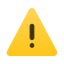
>
> If you are using Google Colab, SQLite is already installed. It may not be installed on your local computer.  If it's not installed, follow the instructions on the [SQLite website](https://www.sqlite.org/download.html) to install it.
>
> The Python interface code is built into Python and you don’t need to install any Python modules for it.


## Setting Up

### Install Requirements

First, install the required Python modules:

In [ ]:
!pip install -qU transformers einops llama-index llama-index-postprocessor-jinaai-rerank  llama-index-llms-huggingface "huggingface_hub[inference]"

### Download the Database

Next, download the SQLite database `videogames.db` from [GitHub](https://github.com/bbrumm/databasestar/tree/main/sample_databases/sample_db_videogames/sqlite) to the local filespace If `wget` is not available on your system, download the database from [this link](https://github.com/bbrumm/databasestar/raw/main/sample_databases/sample_db_videogames/sqlite/videogames.db) and put it in the same directory where you're running this notebook:


In [ ]:
!wget https://github.com/bbrumm/databasestar/raw/main/sample_databases/sample_db_videogames/sqlite/videogames.db

### Download and Run Jina Reranker

The following code will download the model `jina-reranker-v2-base-multilingual` and run it locally:

> 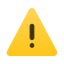
>
>If you're not using a CUDA-enabled system, change the line:
>
>```
reranker_model.to('cuda')
```
>to:
>```
reranker_model.to('cpu')
```

In [ ]:
from transformers import AutoModelForSequenceClassification

reranker_model = AutoModelForSequenceClassification.from_pretrained(
    'jinaai/jina-reranker-v2-base-multilingual',
    torch_dtype="auto",
    trust_remote_code=True,
)

reranker_model.to('cuda') # or 'cpu' if no GPU is available
reranker_model.eval()


### Set up the Interface to Mistral Instruct

We will use LlamaIndex to create a holder object for the connection to the Hugging Face inference API and to the copy of `mistralai/Mixtral-8x7B-Instruct-v0.1` running there.


First, get a Hugging Face access token from your [Hugging Face Account Settings page](https://huggingface.co/settings/tokens).

Enter it when prompted below:

In [ ]:
import getpass

print("Paste your Hugging Face access token here: ")
hf_token = getpass.getpass()

Next, initialize an instance of the `HuggingFaceInferenceAPI` class from LlamaIndex and store it as `mistral_llm`:

In [ ]:
from llama_index.llms.huggingface import HuggingFaceInferenceAPI

mistral_llm = HuggingFaceInferenceAPI(
    model_name="mistralai/Mixtral-8x7B-Instruct-v0.1", token=hf_token
)

## Using SQL-Aware Jina Reranker

We extracted the eight table definitions from the [database import files located on GitHub](https://github.com/bbrumm/databasestar/tree/main/sample_databases/sample_db_videogames/sqlite). Run the command below to put them into a Python list named `table_declarations`:

In [ ]:
table_declarations = ['CREATE TABLE platform (\n\tid INTEGER PRIMARY KEY,\n\tplatform_name TEXT DEFAULT NULL\n);',
 'CREATE TABLE genre (\n\tid INTEGER PRIMARY KEY,\n\tgenre_name TEXT DEFAULT NULL\n);',
 'CREATE TABLE publisher (\n\tid INTEGER PRIMARY KEY,\n\tpublisher_name TEXT DEFAULT NULL\n);',
 'CREATE TABLE region (\n\tid INTEGER PRIMARY KEY,\n\tregion_name TEXT DEFAULT NULL\n);',
 'CREATE TABLE game (\n\tid INTEGER PRIMARY KEY,\n\tgenre_id INTEGER,\n\tgame_name TEXT DEFAULT NULL,\n\tCONSTRAINT fk_gm_gen FOREIGN KEY (genre_id) REFERENCES genre(id)\n);',
 'CREATE TABLE game_publisher (\n\tid INTEGER PRIMARY KEY,\n\tgame_id INTEGER DEFAULT NULL,\n\tpublisher_id INTEGER DEFAULT NULL,\n\tCONSTRAINT fk_gpu_gam FOREIGN KEY (game_id) REFERENCES game(id),\n\tCONSTRAINT fk_gpu_pub FOREIGN KEY (publisher_id) REFERENCES publisher(id)\n);',
 'CREATE TABLE game_platform (\n\tid INTEGER PRIMARY KEY,\n\tgame_publisher_id INTEGER DEFAULT NULL,\n\tplatform_id INTEGER DEFAULT NULL,\n\trelease_year INTEGER DEFAULT NULL,\n\tCONSTRAINT fk_gpl_gp FOREIGN KEY (game_publisher_id) REFERENCES game_publisher(id),\n\tCONSTRAINT fk_gpl_pla FOREIGN KEY (platform_id) REFERENCES platform(id)\n);',
 'CREATE TABLE region_sales (\n\tregion_id INTEGER DEFAULT NULL,\n\tgame_platform_id INTEGER DEFAULT NULL,\n\tnum_sales REAL,\n   CONSTRAINT fk_rs_gp FOREIGN KEY (game_platform_id) REFERENCES game_platform(id),\n\tCONSTRAINT fk_rs_reg FOREIGN KEY (region_id) REFERENCES region(id)\n);']


Now, we define a function that takes a natural language query and the list of table definitions, scores all of them with Jina Reranker, returning them in order from highest scoring to lowest:

In [ ]:
from typing import List, Tuple

def rank_tables(query: str, table_specs: List[str], top_n:int=0) -> List[Tuple[float, str]]:
  # create pairs of [query, table specification]
  pairs = [[query, table_spec] for table_spec in table_specs]
  # pass the pairs to Jina Reranker to get scores for each pair
  scores = reranker_model.compute_score(pairs)
  # create new pairs (score, table specification)
  scored_tables = [(score, table_spec) for score, table_spec in zip(scores, table_specs)]
  # sort the list of pairs from highest to lowest score
  scored_tables.sort(key=lambda x: x[0], reverse=True)
  # return the top n, if specified, or else return all of them
  if top_n and top_n < len(scored_tables):
    return scored_tables[0:top_n]
  return scored_tables

Jina Reranker scores every table definition we give it and by default this function will return all of them with their scores. The optional argument `top_n` limits the number of results returned to a user-defined number, starting with the highest scoring one.

Try it out. First, define a query:

In [ ]:
user_query = "Identify the top 10 platforms by total sales."

Run `rank_tables` to get a list of table definitions back. Let's set `top_n` to 3 to limit the return list size and assign it to the variable `ranked_tables`, then inspect the result:

In [ ]:
ranked_tables = rank_tables(user_query, table_declarations, top_n=3)
ranked_tables

The output should include the tables `region_sales`, `platform` and `game_platform`, which all seem to be reasonable places to look for an answer to the query.

## Using Mistral Instruct to Generate SQL

We're going to have Mistral Instruct v0.1 write an SQL query that fulfils the user's query, based on the declarations of the top three tables according to the reranker.

First, we make a prompt for that purpose using LlamaIndex' `PromptTemplate` class:

In [ ]:
from llama_index.core import PromptTemplate

make_sql_prompt_tmpl_text = (
    """
Generate a SQL query to answer the following question from the user:
\"{query_str}\"

The SQL query should use only tables with the following SQL definitions:

Table 1:
{table_1}

Table 2:
{table_2}

Table 3:
{table_3}

Make sure you ONLY output an SQL query and no explanation.
"""
)
make_sql_prompt_tmpl = PromptTemplate(make_sql_prompt_tmpl_text)

We use the `format` method to fill in the template fields with the user query and top three table declarations from Jina Reranker:

In [ ]:
make_sql_prompt = make_sql_prompt_tmpl.format(query_str=user_query,
                                              table_1=ranked_tables[0][1],
                                              table_2=ranked_tables[1][1],
                                              table_3=ranked_tables[2][1])

You can see the actual text we're going to pass to Mistral Instruct:

In [ ]:
print(make_sql_prompt)

Now let's send the prompt to Mistral Instruct and retrieve its response:

In [ ]:
response = mistral_llm.complete(make_sql_prompt)
sql_query = str(response)
print(sql_query)

## Running the SQL query

Use the built-in Python interface to SQLite to run the query above
against the database `videogames.db`:

In [ ]:
import sqlite3

con = sqlite3.connect("videogames.db")
cur = con.cursor()
sql_response = cur.execute(sql_query).fetchall()

For details on the interface to SQLite, [see the Python3 documentation](https://docs.python.org/3/library/sqlite3.html).

Inspect the result:

In [ ]:
sql_response

You can check if this is correct by running your own SQL query. The sales data stored in this database is in the form of floating point numbers, presumably thousands or millions of unit sales.

## Getting a Natural Language Answer

Now we will pass the user's query, the SQL query, and the result back to Mistral Instruct with a new prompt template.

First, make the new prompt template using LlamaIndex, the same as above:

In [ ]:
rag_prompt_tmpl_str = (
    """
Use the information in the JSON table to answer the following user query.
Do not explain anything, just answer concisely. Use natural language in your
answer, not computer formatting.

USER QUERY: {query_str}

JSON table:
{json_table}

This table was generated by the following SQL query:
{sql_query}

Answer ONLY using the information in the table and the SQL query, and if the
table does not provide the information to answer the question, answer
"No Information".
"""
)
rag_prompt_tmpl = PromptTemplate(rag_prompt_tmpl_str)

We will convert the SQL output into JSON, a format Mistral Instruct v0.1
understands.

Populate the template fields:

In [ ]:
import json

rag_prompt = rag_prompt_tmpl.format(query_str="Identify the top 10 platforms by total sales",
                                    json_table=json.dumps(sql_response),
                                    sql_query=sql_query)

Now solicit a natural language response from Mistral Instruct:

In [ ]:
rag_response = mistral_llm.complete(rag_prompt)
print(str(rag_response))

## Try it yourself

Let's organize all that into one function with exception trapping:

In [ ]:
def answer_sql(user_query: str) -> str:
  try:
    ranked_tables = rank_tables(user_query, table_declarations, top_n=3)
  except Exception as e:
    print(f"Ranking failed.\nUser query:\n{user_query}\n\n")
    raise(e)

  make_sql_prompt = make_sql_prompt_tmpl.format(query_str=user_query,
                                                table_1=ranked_tables[0][1],
                                                table_2=ranked_tables[1][1],
                                                table_3=ranked_tables[2][1])

  try:
    response = mistral_llm.complete(make_sql_prompt)
  except Exception as e:
    print(f"SQL query generation failed\nPrompt:\n{make_sql_prompt}\n\n")
    raise(e)

  # Backslash removal is a necessary hack because sometimes Mistral puts them
  # in its generated code.
  sql_query = str(response).replace("\\", "")

  try:
    sql_response = sqlite3.connect("videogames.db").cursor().execute(sql_query).fetchall()
  except Exception as e:
    print(f"SQL querying failed. Query:\n{sql_query}\n\n")
    raise(e)

  rag_prompt = rag_prompt_tmpl.format(query_str=user_query,
                                      json_table=json.dumps(sql_response),
                                      sql_query=sql_query)
  try:
    rag_response = mistral_llm.complete(rag_prompt)
    return str(rag_response)
  except Exception as e:
    print(f"Answer generation failed. Prompt:\n{rag_prompt}\n\n")
    raise(e)

Try it out:

In [ ]:
print(answer_sql("Identify the top 10 platforms by total sales."))

Try some other queries:

In [ ]:
print(answer_sql("Summarize sales by region."))

In [ ]:
print(answer_sql("List the publisher with the largest number of published games."))

In [ ]:
print(answer_sql("Display the year with most games released."))

In [ ]:
print(answer_sql("What is the most popular game genre on the Wii platform?"))

In [ ]:
print(answer_sql("What is the most popular game genre of 2012?"))

Try your own queries:


In [ ]:
print(answer_sql("<INSERT QUESTION OR INSTRUCTION HERE>"))

## Review and Conclusions

We've shown you how to make a very basic RAG (retrieval-augmented generation) system for natural language question-answering that uses an SQL database as an information source.  In this implementation, we use the same large language model (Mistral Instruct v0.1), to generate SQL queries and to construct natural language responses.

The database here is a very small example one, and to scale this up might demand a more sophisticated approach than just ranking a list of table definitions. You might want to use a two-stage process, where an embedding model and vector store initially retrieve more results, but the reranker model prunes that down to whatever number you are able to put into a prompt for an generative language model.

This notebook has assumed no request requires more than three tables to satisfy, and obviously in practice this cannot always be true. Mistral 7B Instruct v0.1 is not guaranteed to produce correct (or even executable) SQL output. In production, something like this requires much more in-depth error handling.

More sophisticated error handling, longer input context windows, and generative models specialized in SQL-specific tasks might make a big difference in practical applications.

Nonetheless, you can see here how the RAG concept extends to structured databases, expanding its scope for use dramatically.